# Introduction

Here we will be looking and Policy and Value Iteration methods and their convergence in practice. We implement all methods from scratch and evaluate them on a Gridworld model. We find that Value Iteration methods perform as expected as compared to other sources and as expected with theoretical guarantees. Further we qualitatively validate that the policies produced are intuitive.

## Value Iteration

In the next section of the notebook, we will be looking at convergence rates of Value Iteration methods. In particular, we will be demonstrating Gauss-Seidel, Jacobi, Gauss-Seidel-Jacobi, and Prioritized Sweeping variations on plain Value Iteration.

Various resources that can help with the understanding of these methods can be found here:

**Prioritized sweeping:**

http://webdocs.cs.ualberta.ca/~sutton/book/ebook/node98.html

http://ipvs.informatik.uni-stuttgart.de/mlr/wp-content/uploads/2016/04/02-MarkovDecisionProcess.pdf

http://www.jmlr.org/papers/volume6/wingate05a/wingate05a.pdf

**Jacobi, Gauss-Seidel, Gauss-Seidel-Jacobi:**

(Shlakhter Oleksandr thesis)
https://tspace.library.utoronto.ca/bitstream/1807/24381/6/Shlakhter_Oleksandr_201003_PhD_thesis.pdf

**Gauss-Seidel:**

http://ipvs.informatik.uni-stuttgart.de/mlr/wp-content/uploads/2016/04/02-MarkovDecisionProcess.pdf

**Prioritized sweeping:**

(Li and Littman) https://pdfs.semanticscholar.org/7824/11081e754b72da6565c41f3904de843b31d1.pdf

**Other papers comparing methods:**

(Hoey and Grzes)
https://kar.kent.ac.uk/48658/1/grzes13ijcnn.pdf

(Shlakhter Oleksandr thesis)
https://tspace.library.utoronto.ca/bitstream/1807/24381/6/Shlakhter_Oleksandr_201003_PhD_thesis.pdf

In addition sections 6.3 of Puterman (1994) and the Sutton Reinforcement Learning text have detailed descriptions of theoretical methods.

To better understand Value Iteration, let's generate the optimal Value functions and policies and compare how fast each method converges!


In [1]:
from mdp_matrix import GridWorld
from value_iteration_matrix import ValueIteration, GaussSeidelValueIteration, JacobiValueIteration, PrioritizedSweepingValueIteration, GaussSeidelJacobiValueIteration
from policy_iteration import policy_iteration, modified_policy_iteration, policy_iteration_by_inversion
import matplotlib.pyplot as plt
import numpy as np
import pprint
from operator import itemgetter
from IPython.display import Image
from IPython.core.display import HTML 
from IPython.display import Latex

## Grid world
For our experiments, we set up a grid world MDP similar to the one shown on Sutton page 82.

In [2]:
Image(url= "https://webdocs.cs.ualberta.ca/~sutton/book/ebook/figtmp15.png")

In [3]:
test_rewards = [[i, j, -1] for i in range(5) for j in range(5)]
test_rewards[2] = [0, 2, 1]
test_rewards[23] = [4,3,1]

# Instantiate the gridworld
gw = GridWorld(5, test_rewards)
pprint.pprint(np.reshape(gw.R, (5,5)))

array([[-1., -1.,  1., -1., -1.],
       [-1., -1., -1., -1., -1.],
       [-1., -1., -1., -1., -1.],
       [-1., -1., -1., -1., -1.],
       [-1., -1., -1.,  1., -1.]])


First run to optimal value at epsilon 0.001....
||V1 - V0|| = 4.500000
Converged in 1675 iterations (67 sweeps)
Now evaluating policies...

Value Iteration
||V1 - V0|| = 4.500000
Converged in 1125 iterations (45 sweeps)

GS
||V1 - V0|| = 3.855664
Converged in 1125 iterations (45 sweeps)

J
Converged in 150 iterations (6 sweeps)

GSJ
Converged in 150 iterations (6 sweeps)

PS
Converged in 1189 iterations


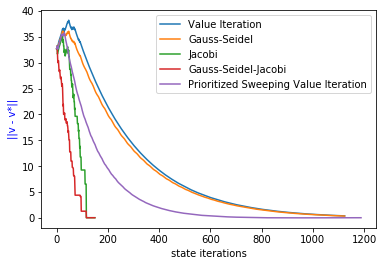

Example optimal policy
[['E' 'E' 'N' 'W' 'W']
 ['E' 'E' 'N' 'N' 'N']
 ['E' 'E' 'N' 'S' 'S']
 ['S' 'S' 'S' 'S' 'S']
 ['E' 'E' 'E' 'S' 'W']]


In [4]:
%matplotlib inline

vl = ValueIteration(gw)

print("First run to optimal value at epsilon 0.001....")
optimal_policy, optimal_value, _  = vl.run()

print("Now evaluating policies...\n")

print("Value Iteration")
optimal_policy, v, vs = vl.run(optimal_value=optimal_value, theta=0.01)
plt.plot(vs)

print("\nGS")

vl = GaussSeidelValueIteration(gw)

optimal_policy, v, vsgs = vl.run(optimal_value=optimal_value, theta=0.01)
plt.plot(vsgs)

print("\nJ")
vl = JacobiValueIteration(gw)
optimal_policy, v, vsj = vl.run(optimal_value=optimal_value, theta=0.01)
plt.plot(vsj)

print("\nGSJ")
vl = GaussSeidelJacobiValueIteration(gw)
optimal_policy, v, vsj = vl.run(optimal_value=optimal_value, theta=0.01)
plt.plot(vsj)

print("\nPS")
vl = PrioritizedSweepingValueIteration(gw)
optimal_policy, v, vsps = vl.run(optimal_value=optimal_value)
plt.plot(vsps)

plt.xlabel('state iterations')
plt.ylabel('||v - v*||',color='b')

plt.legend(['Value Iteration', 'Gauss-Seidel', 'Jacobi', 'Gauss-Seidel-Jacobi', 'Prioritized Sweeping Value Iteration'], loc='upper right')

plt.show()

print("Example optimal policy")
print(np.array([gw.actions[x] for x in optimal_policy.values()]).reshape((5,5)))



## What just ran?

As you can see from the above, we found the optimal policies and value functions for a simple GridWorld problem.

Inspecting the policy, we find that it converges to an intuitive and correct policy.

As you can see, Gauss-Seidel-Jacobi and Jacobi splitting methods appear to perform the best in practice on such a small GridWorld, quickly dropping to the optimal Value function. We chalk this up to the sparse nature of the transition matrix in our problem, as you'll see later on with a larger GridWorld, Jacobi performs more smoothly along with theoretical expectations as seen in Puterman. Prioritized sweeping outperforms VI and GS as would be expected from the comparisons seen the Oleksandr thesis and papers presenting PS (linked above).

## What about the theory?

### Value Iteration
Formally, Value Iteration requires an infinite amount of steps to converge to V*.

See https://webdocs.cs.ualberta.ca/~sutton/book/4/node5.html

However, according to Puterman (1994), we can approximate the number of additional iterations required to produce a value function within some epsilon error of optimal.

From page 164 of Puterman, 6.3.8, here lambda = .9, and from above ||v1 - v0|| = 4.500000 and epsilon = .01

Then $.01 \le \frac{2*.9^n}{1-.9}*4.5$ and solving for n yields: 86 (sweeps). Here we use v1-v0 to be the difference between the first and second sweep. 

As you can see, in practice on a small grid, value iteration only requires 45 sweeps.


### Gauss-Seidel 

For Gauss-Seidel iteration estimation's theoretical number of iterations required, we follow Puterman p.171

We need to find $\sigma(Q^{-1}R) \le \alpha$. That is we need to find the spectral radius of the QR decomposition of the transition matrix. This provides us with an estimate for the number of iterations to converge to optimal as in Value Iteration above, instead of using the discount factor.


In [5]:
import numpy
import scipy.linalg

max_alpha = None
for a in range(gw.A):
    L, U = numpy.tril(gw.T[:,a,:], k=-1), numpy.triu(gw.T[:,a,:])
#     print(numpy.diag(L))

    Q = np.eye(gw.S) - .9*L
    R = .9*U
#     print(numpy.linalg.inv(Q).dot(R))
    w = numpy.linalg.eigvals(numpy.linalg.inv(Q).dot(R))
#     print(w)
#     print(V)
    alpha = max(w)
    if not max_alpha or alpha > max_alpha:
        max_alpha = alpha

print(max_alpha)
    

0.9


So in our example, actually the $\alpha$ value is equivalent to the $\gamma$ discount factor. Hence, by Puterman (1994) p.171, we find that Value Iteration and Gauss-Seidel will converge in the same number of iterations.

In practice, we see that this is true, but Gauss-Seidel converges at a slightly faster right at the beginning.


### Jacobi

In Jacobi value iteration, the decomposition for finding $\alpha$ is slightly different. See page 172 of Puterman. Loosely, we know that Jacobi will outperform Value Iteration in convergence iterations when all the values of the diagonal in the Transition matrix are > 0. More specifically, we decompose the transition matrix into $Q, R$ as per Puterman p.172 as seen below. As seen in the graph below where we run Value Iteration methods on a much larger GridWorld, we see similar performance increases as in Puterman, but in a smaller GridWorld, Jacobi outperforms other methods. We suspect this is due to the sparsity of the transition matrix of the small GridWorld. However, according to Puterman, Jacobi should converge in less than or equal to the number of iterations of Value Iteration, but in more iterations than GS. This is something we observe in a larger grid below when comparing Policy Iteration as well.



In [6]:
import numpy
import scipy.linalg

max_alpha = None
for a in range(gw.A):
    copy = gw.T[:,a,:].copy()
    np.fill_diagonal(copy, 0.)
    R, Q = .9*copy, numpy.diag(1. - .9*numpy.diag(gw.T[:,a,:]))
#     print(numpy.diag(Q))
    QRinv = numpy.linalg.inv(Q).dot(R)
    
    w = numpy.linalg.eigvals(QRinv)
    alpha = max(w)
    if not max_alpha or alpha > max_alpha:
        max_alpha = alpha



### Prioritized Sweeping

In PrioritizedSweeping, Li and Littman (see link at top of notebook) prove convergence guarantees. But offer no theoretical number of iterations it should converge in.

### Overall Convergence

We find that Gauss-Seidel-Jacobi is the fastest converging method in practice as per the graphs demonstrated above. We find that theoretical values align with our implemented methods. Furthermore, they align with Puterman's demonstration below and with Shlakhter's thesis comparing such methods at the University of Toronto (see link at top of notebook). Puterman doesn't offer convergence estimates for PrioritizedSweeping, but we find in practice that it performs as well as GSJ (see below for a larger sample). See p.10 of Shlakhter's thesis for more information about these methods and another comparison on convergence rates, see Hoey and Grzes (link at top of notebook).

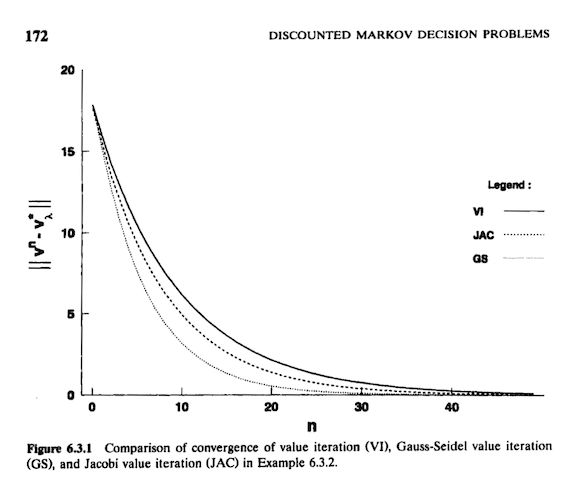

In [7]:
Image(filename="book_iterations.png")


# Policy Iteration
We'll now run policy iteration on the same gridworld MDP in three ways:
- Policy iteration using value iteration
- Policy iteration using matrix inversion
- Modified policy iteration (Puterman section 6.5)

### Policy Iteration by Matrix Inversion
Policy iteration by matrix inversion evaluates the policy using the following closed form expression:

In [8]:
%%latex
\begin{align} 
V &=PR + \gamma PV\\
\Leftrightarrow (I-\gamma P) V &= PR\\
\Rightarrow V &= (I-\gamma P)^{-1} PR 
\end{align}

<IPython.core.display.Latex object>

### Modified Policy Iteration
The modified policy iteration algorithm presented in Puterman starts with a round of policy improvement and then does policy evaluation up to a maximum of m times, before going back to policy improvement...etc.

Converged in 5 iterations, 2400 evaluations
Converged in 4 iterations, 4 evaluations
Converged in 4 iterations, 500 evaluations


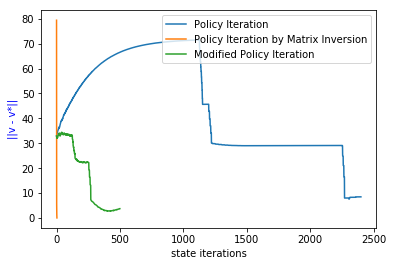

In [9]:
%matplotlib inline
epsilon = 0.01
gamma = 0.9

m = 5

V_pi, pol_pi, n_iter_pi, vs_pi = policy_iteration(gw, gamma, epsilon, optimal_value)
plt.plot(vs_pi)

V_inv, pol_inv, n_iter_inv, vs_inv = policy_iteration_by_inversion(gw, gamma, optimal_value)
plt.plot(vs_inv)

V_modpi, pol_modpi, n_itermodpi, vs_modpi = modified_policy_iteration(gw, gamma, epsilon, m, optimal_value)
plt.plot(vs_modpi)

plt.xlabel('state evaluations')
plt.ylabel('||v - v*||',color='b')

plt.legend(['Policy Iteration', 'Policy Iteration by Matrix Inversion', 'Modified Policy Iteration'], loc='upper right')

plt.show()


### Notes
Notice the initial ramp up in error for policy iteration. This is due to the initial policy evaluation taking a long time to reach convergence. Once it reaches it comes in policy improvement which then starts driving down the error.

Modified policy iteration doesn't have this initial ramp up as it starts off with policy improvement directly.

And policy iteration by matrix inversion doesn't take many iterations because it evaluates policies non-iteratively. However it does involve a matrix inverse. Note that our graph here is comparing number of iterations over state evaluations, so this does not take into account matrix inversion as we do not iterate over state updates V(s). Instead, we suggest you look at the number of algorithm iterations for PI, PI via MI and Modified PI. as you can see they all take between 4-5 iterations of the algorithm.

## Convergence in theory
### Policy Iteration
For policy iteration convergence is guaranteed for a finite MDP. And, by theorem 6.4.6 in Puterman:
The sequence of values $v^n$ generated by policy iteration converges monotonically and in norm to v*.
Thus policy iteration converges at least linearly.

It is however quadratic under specific conditions (See theorem 6.4.8 in Puterman)

### Modified Policy Iteration
The modified policy iteration algorithm's convergence is at least linear as shown by theorem 6.5.6 (Puterman).

## VI vs PI
Now we'll compare both approaches in terms of iterations over state values. Note! As in value iteration, we label "state iterations" as the number of times we evaluate a given V(s). This is so that we can compare prioritized sweeping. The number of sweeps (or iterations of the algorithm) are described inline as logging statements.

Let's start by making a larger gridworld MDP

In [12]:
dim = 10
test_rewards_2 = [[i, j, -1] for i in range(dim) for j in range(dim)]
test_rewards_2[0] = [0, 0, 1]
test_rewards_2[99] = [9, 9 ,1]

# Instantiate the gridworld
gw2 = GridWorld(dim, test_rewards)

Value Iteration
||V1 - V0|| = 3.923009
Converged in 6700 iterations (67 sweeps)
||V1 - V0|| = 3.923009
Converged in 4500 iterations (45 sweeps)
took 1003.599 ms

GS Value Iteration
||V1 - V0|| = 4.812849
Converged in 4500 iterations (45 sweeps)
took 969.850 ms

Jacobi Value Iteration
Converged in 4000 iterations (40 sweeps)
took 937.399 ms

GSJ Value Iteration
Converged in 2000 iterations (20 sweeps)
took 461.307 ms

Prioritized Sweeping Iteration
Converged in 4105 iterations
took 4215.935 ms

Policy Iteration
Converged in 11 iterations, 8000 evaluations
took 968.736 ms

Modified Policy Iteration
Converged in 11 iterations, 5200 evaluations
took 777.429 ms


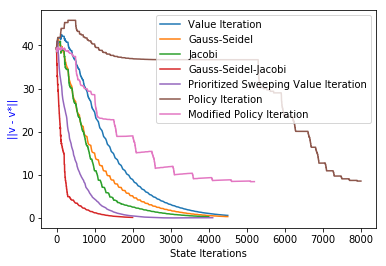

In [18]:
%matplotlib inline

import time

vl = ValueIteration(gw2)

print("Value Iteration")

optimal_policy, optimal_value, _  = vl.run()
time1 = time.time()
optimal_policy, v, vs = vl.run(optimal_value=optimal_value, theta=0.01)
time2 = time.time()
print 'took %0.3f ms' % ((time2-time1)*1000.0)
plt.plot(vs)

vl = GaussSeidelValueIteration(gw2)

print("\nGS Value Iteration")

time1 = time.time()
optimal_policy, v, vsgs = vl.run(optimal_value=optimal_value, theta=0.01)
time2 = time.time()
print 'took %0.3f ms' % ((time2-time1)*1000.0)
plt.plot(vsgs)

print("\nJacobi Value Iteration")

vl = JacobiValueIteration(gw2)
time1 = time.time()
optimal_policy, v, vsj = vl.run(optimal_value=optimal_value, theta=0.01)
time2 = time.time()
print 'took %0.3f ms' % ((time2-time1)*1000.0)
plt.plot(vsj)

print("\nGSJ Value Iteration")

vl = GaussSeidelJacobiValueIteration(gw2)
time1 = time.time()
optimal_policy, v, vsj = vl.run(optimal_value=optimal_value, theta=0.01)
time2 = time.time()
print 'took %0.3f ms' % ((time2-time1)*1000.0)
plt.plot(vsj)

print("\nPrioritized Sweeping Iteration")

vl = PrioritizedSweepingValueIteration(gw2)
time1 = time.time()
optimal_policy, v, vsps = vl.run(optimal_value=optimal_value, max_iterations=100000)
time2 = time.time()
print 'took %0.3f ms' % ((time2-time1)*1000.0)
plt.plot(vsps)

print("\nPolicy Iteration")

time1 = time.time()
V_pi, pol_pi, n_iter_pi, vs_pi = policy_iteration(gw2, gamma, epsilon, optimal_value)
time2 = time.time()
print 'took %0.3f ms' % ((time2-time1)*1000.0)
plt.plot(vs_pi)

print("\nModified Policy Iteration")

time1 = time.time()
V_modpi, pol_modpi, n_itermodpi, vs_modpi = modified_policy_iteration(gw2, gamma, epsilon, m, optimal_value)
time2 = time.time()
print 'took %0.3f ms' % ((time2-time1)*1000.0)
plt.plot(vs_modpi)

plt.xlabel('State Iterations')
plt.ylabel('||v - v*||',color='b')

plt.legend(['Value Iteration', 'Gauss-Seidel', 'Jacobi',
            'Gauss-Seidel-Jacobi', 'Prioritized Sweeping Value Iteration',
            'Policy Iteration',
            'Modified Policy Iteration'], loc='upper right')

plt.show()


## Note
As we can see, the policy iteration algorithm and its modified version converge the fastest in terms of number of algorithm iterations (at 11 iterations) but do not eliminate the error entirely. The policy evaluation has been stopped short because the policy improvement step has found no better policy than the current one, which is the optimal policy. 

This result is in line with the proof of theorem 6.4.6 (Puterman) which :
"compares the iterates of policy iteration to those of value iteration, and shows that if policy iteration and value iteration begin at the same point, then the iterates of policy iteration are always bounded below by those of value iteration and above by v*"

However, in terms of number of state evaluations, V(s), we see that GSJ and Prioritized sweeping converge at the fastest rate, with GSJ performing almost as well as Policy Iteration in number of algorithm iterations.

### Timing

As per the timing information, we see that GSJ takes the least amount of overall tim t